# **Data Structures Project 2**
- **Project Name:** Social Network
- **Project Description:** Design a simplified social network that relies heavily on using different data structures. An idea adapted from [LeetCode's Design Twitter Problem](https://leetcode.com/problems/design-twitter/).
- **Group Members:**
  * Yousef Mohammed Gaber Mohammed Saad (120180002)
  * Lamiaa Samir Mohamed Ahmed Elmahy (120180008)
  * Mazen Muhammad Saad Ali Khodier (120180019)
  * Omar Alaaeldein Hamdy Ramadan Ahmed (120180022)
  * Ahmed Elshahat Saad Abdelazeez Dawood (120180038)

# Initialization

In [ ]:
# Importing Necessary Libraries
from collections import deque, OrderedDict
import networkx as nx
import matplotlib.pyplot as plt
import heapq as hq
import time
from datetime import datetime
from difflib import get_close_matches
from prettytable import PrettyTable

# Post Class

In [ ]:
class Post:
    _ID = 1
    def __init__(self, author, postBody, atTime):
      """
      Attributes:
        id: a unique ID automatically made for each post
        author: the writer of the post, an object of type user
        postBody: the content of the post as a string
        time: the time at which the post was made
        next: a pointer to the most recent post made by the same user before this one
        reacts: a dictionary for keeping track of users reacting on this post
        shares: a counter for the number of shares on this post
      """
      self.id = Post._ID
      Post._ID += 1
      
      self.author = author
      self.postBody = postBody
      self.time = atTime
      
      self.next = None
      self.reacts = {}
      self.shares = 0

# User Class

In [ ]:
class User:
  _ID = 1
  def __init__(self, name):
    """
    Attributes:
      id: a unique ID automatically made for each user upon being added to the network
      name: the name of the user as string
      following: a set for keeping track of the users followed by this user
      sharedposts: an ordered dictionary for storing the posts shared with the user by others
      notifications: a double ended queue for storing the 5 most recent notifications for the user
      head: a pointer to the most recent post made by the user
    """
    self.id = User._ID
    User._ID += 1
    self.name = name
    self.following = {self.id}
    self.sharedposts = OrderedDict()
    self.notifications = deque(maxlen=5)
    self.head = None

  def _post(self, postBody, time):
    """
    Private method called inside the social network methods
    Makes a new post by the user at a certain time
    """
    tail = self.head
    new_post = Post(self, postBody, time)
    new_post.next = tail
    self.head = new_post
    return new_post

  def _follow(self, id):
    self.following.add(id)

  def _unfollow(self, id):
    if id != self.id:
      self.following.discard(id)

  def _share_with(self, user2, post, atTime):
    key = (post.id, user2.id)
    if key not in self.sharedposts:
      self.sharedposts[key] = atTime
      post.shares += 1
    else:
      print("You have already shared this post with this user!")

# Server Class

In [ ]:
class Server:
    def __init__(self):
        """
        Description:
          Stores the required data structures used intensely in the social network class
        
        Attributes:
          graph: A directed graph for storing relations between users while maintaining their degrees
          users: a hash table (dictionary) with user ids as keys and values are the user themselves as an object 
          posts: a dictionary of post ids as keys and posts objects as values
          users_search_dict: a dictionary with keys as user names and values as their ids
        """
        self.graph = nx.MultiDiGraph()
        self.users = {}
        self.posts = {}
        self.users_search_dict = {}

# Social Network Class

In [ ]:
class SocialNetwork:
    def __init__(self):
        self.server = Server()

    # -----------------------------------------------------------------
    def follow(self, followerId, followeeId) -> None:
        """
        Follower follows a followee.
        If the operation is invalid, no operation is done.
        """     
        if not self.server.graph.has_edge(followerId, followeeId):
            self.server.graph.add_edge(followerId, followeeId)
            follower_user = self.server.users[followerId]
            followee_user = self.server.users[followeeId]
            follower_user._follow(followee_user.id)

    # -----------------------------------------------------------------
    def unfollow(self, followerId, followeeId) -> None:
        """
        Follower unfollows a followee.
        If the operation is invalid, no operation is done.
        """
        if self.server.graph.has_edge(followerId, followeeId):
            self.server.graph.remove_edge(followerId, followeeId)
            follower_user = self.server.users[followerId]
            followee_user = self.server.users[followeeId]
            follower_user._unfollow(followee_user.id)

    # -----------------------------------------------------------------
    def add_user(self, new_user):
        """
        takes an instance of the User class to be added to the social network database       
        """
        # prevent existance of two identical names
        assert new_user.name not in self.server.users_search_dict.keys(),\
            "This username is already taken. Please try another one"
 
        # Update server data
        self.server.users[new_user.id] = new_user
        self.server.users_search_dict[new_user.name] = new_user.id      
        self.server.graph.add_node(new_user.id)

    # -----------------------------------------------------------------
    def new_post(self, userId, postBody) -> None:
        """
        User composes a new post with string body at a certain time.
        """
        # Get current time
        atTime = time.time()
        atTime = datetime.fromtimestamp(atTime).strftime("%A, %B %d, %Y %I:%M:%S")
        current_user = self.server.users[userId]
        new_post = current_user._post(postBody, atTime)
        self.server.posts[new_post.id] = new_post
        return new_post.id

    # -----------------------------------------------------------------
    def getNewsFeed(self, userId) :#-> List[int]:
        """
        Retrieve the 5 most recent posts in the user's news feed.
        Each item in the news feed must be posted by
        the user himself, user's followees (1st degree relation)
        or followees of followees up to 3rd degree. Also, (if implemented)
        include shared posts with a user in his/her news feed.
        Posts must be ordered from most recent to least recent.
        """
        current_user = self.server.users[userId]
        # get posts shared with the user in order of most recent to oldest
        shared = list(reversed(current_user.sharedposts.items()))
        current_share, end = 0, len(shared)
        # get the posts written by the user and their followees (up to 3rd degree) using BFS
        users_ids = self._get_neighbours(userId, degree=3)
        # build a max heap with the most recent post of each user of interest
        heap = self._build_heap(users_ids)
        feed = []

        while len(feed) < 5 and heap:
            # check which of is more recent from shared and written posts
            # and then add it to the previously initialized feed list
            if current_share < end:
              if shared[current_share][1] > heap[0][0]:
                feed.append(("share", shared[current_share][0], shared[current_share][1]))
                current_share += 1
            else:  
                time, id, head, degree = hq._heappop_max(heap) 
                feed.append(("post", head.id, degree))
                if head.next:
                    heap.append((head.next.time, head.next.id, head.next, degree))
                    hq._heapify_max(heap)
        
        # print the results in a user-friendly manner
        News_Feed = PrettyTable()
        News_Feed.field_names = ["News Feed for {}".format(current_user.name)]
        for output in feed:
          News_Feed.add_row([self._print_feed(output)])
          News_Feed.add_row(['\n'])
        print(News_Feed)

    
    def _get_neighbours(self, userId, degree):
        """
        traverse a graph using Breadth-First_search (BFS) from a certain node up
        to a certain degree of neighbours
        Returns: a list of tuples; the first element being the node and the second being
        its degree in relation to the starting node (the starting node itself is considered to be of order 0)
        """
        temp = dict(nx.algorithms.bfs_successors(self.server.graph, userId, depth_limit=degree))
        up_to_nth = [(userId, 0)]
        degree = 1
        for i in temp.values():
            new_nodes = list(i)
            up_to_nth += [(node, degree) for node in new_nodes]
            degree += 1
        return up_to_nth
    
    def _build_heap(self, users):
        """
        returns a max heap according to the most recent time
        """
        heap = []
        for user in users:
            u_id, degree = user[0], user[1]
            current_user = self.server.users[u_id]
            if current_user.head:
                data = (current_user.head.time, u_id, current_user.head, degree)
                heap.append(data)
                hq._heapify_max(heap)
        return heap
 
    def _print_feed(self, output):
      """
      prints the feed in a presentable manner using the PrettyTable module
      """
      if output[0] == "post":
        post = self.server.posts[output[1]]
        author = post.author
        degree = output[2]
        table = PrettyTable()
        table.field_names = ['By {} (Degree: {})'.format(author.name, degree)]
        table.add_row(["@Time: {}".format(post.time)])
        table.add_row(['\n'])
        table.add_row([post.postBody])
        table.add_row(['\n'])
        table.add_row(["Shares: {}  Reacts: {}".format(post.shares, len(post.reacts))])
        return table
        
      elif output[0] == "share":
        user = self.server.users[output[1][1]]
        post = self.server.posts[output[1][0]]
        time = output[2]
        author = post.author
        table = PrettyTable()
        table.field_names = ['{} has shared the following post with you!'\
                             .format(user.name)]
        table.add_row(['@Time: {}'.format(time)])
        table2 = PrettyTable()
        table2.field_names = ['By {}'.format(author.name)]
        table2.add_row(["@Time: {}".format(post.time)])
        table2.add_row(['\n'])
        table2.add_row([post.postBody])
        table2.add_row(['\n'])
        table2.add_row(["Shares: {}  Reacts: {}".format(post.shares, len(post.reacts))])
        table.add_row([table2])
        return table

    # -----------------------------------------------------------------
    def react(self, userId, postId) -> None:
        """
        User reacts to a post at a certain time.
        If react() is called twice, the user un-reacts to the post.
        """
        atTime = time.time()
        atTime = datetime.fromtimestamp(atTime).strftime("%A, %B %d, %Y %I:%M:%S")
        current_post = self.server.posts[postId]
        
        if userId in current_post.reacts:
            current_post.reacts.pop(userId)
        else:
            current_post.reacts[userId] = atTime
            current_user = self.server.users[userId]
            current_user.notifications.append(['react', userId, postId, atTime])
 
    # --- BONUS -------------------------------------------------------
    def getNotifications(self, userId) -> None:
        """
        Retrieve the 5 most recent user's notifications.
        When user A reacts to post of user B or shares a post
        with user B, this accounts for notification for user B.
        Notifications are ordered from most recent to least recent.
        :param userId: retrieve the 5 most current notification for that userId.
        :return PrettyTable() object my_table which contains the notifications.
        """
        notifications = self.server.users[userId].notifications
        my_table = PrettyTable()
        my_table.field_names = ["Type", "From user", "postId", "@time"]
        my_table.title='Recent notifications for {}'.format(self.server.users[userId].name)
        [my_table.add_row([i[0], i[1], i[2], i[3]]) for i in reversed(list(notifications))]
        return my_table        
        
    # --- BONUS -------------------------------------------------------
    def search(self, userName) :#-> List[int]:
        """
        Provided certain name, search for the matching users' Ids by creating a
        list of the user ids corresponding to the close matches of the searched user name.
        In case no close matches of the searched user name are found at all 
        it returns the message "User not found".
        In case matching user names are found, itcalls the private 
        _print_search method to show the search results in a user-friendly manner.
        """
        userName_ = userName.split()[0]
        similar_names = get_close_matches(userName_, self.server.users_search_dict.keys())
        names_ids = []
        for name in similar_names:
            names_ids.append(self.server.users_search_dict[name])
        if not names_ids:
            return "{} not found!!!".format(userName)
        self._print_search(userName, similar_names, names_ids)
        
    def _print_search(self, target, names, ids):
        table = PrettyTable()
        table.title = 'Similar Results to {}'.format(target)
        table.field_names = ['Similar users', 'Users\' ID']
        for i in range(len(names)):
            table.add_row([names[i], ids[i]])
        print(table)
    
    # --- BONUS -------------------------------------------------------
    def share(self, userId, postId, usersIds) -> None:
        """
        User shares a post to a group of users.
        Disallow sharing a post twice with a user where this post
        has been already shared with.
        """
        atTime = time.time()
        atTime=datetime.fromtimestamp(atTime).strftime("%A, %B %d, %Y %I:%M:%S")
        sharing_user = self.server.users[userId]
        shared_post = self.server.posts[postId]
        for user in usersIds:
            current_user = self.server.users[user]
            sharing_user._share_with(current_user, shared_post, atTime)
            current_user.notifications.append(['share', userId, postId, atTime])

# Testing

In [ ]:
def Test():
    #making the social network
    s = SocialNetwork()

    #making the users
    omar,mazen,ahmed,yousef,lamiaa=[User('omar'),User('mazen'),User('ahmed'),User('yousef'),User('lamiaa')]     # IDs:  1,2,3,4,5


    #adding the users
    s.add_user(omar)
    s.add_user(mazen)
    s.add_user(ahmed)
    s.add_user(yousef)
    s.add_user(lamiaa)


    #people following each other
    s.follow(1,2)
    s.follow(1,5)
    s.follow(2,3)
    s.follow(2,4)
    s.follow(3,2)
    s.follow(3,4)
    s.follow(4,3)
    s.follow(4,1)
    s.follow(5,1)
    s.follow(5,2)

    # posting
    s.new_post(2,'hello people im mazen proud to be an ejustian')   #mazen posting (post 1)
    time.sleep(1)
    s.new_post(3,'im dawood and proud but not as much')             #dawood posting (post 2)
    time.sleep(1)
    s.new_post(4,'idk i dont really care')                          #yousef posting (post 3)
    time.sleep(1)
    s.new_post(1,'Ejust is a GoOd place lol')                       #omar posting (post 4)
    time.sleep(1)
    s.new_post(5,'I love ejust it is my new home')                  #lamiaa posting (post 5)
    time.sleep(1)
    s.new_post(2,'i want to sleep ')                                #mazen posting again (post 6)
    time.sleep(1)
    s.new_post(2,'im tired')                                        #mazen posting again again (post 7)
    time.sleep(1)
    s.new_post(2,'reports and projects everywhere')                 #mazen posting again again again , i swear if he posted one more time (post 8)
    time.sleep(1)
    s.new_post(2,'finals lol')                                      #mazen posting again , that's it im unsubscribing (post 9)
    time.sleep(1)
    s.new_post(3,'enough posts ya mazen ENOUGHHHH')                 #dawood posting (post 10)
    time.sleep(1)

    plt.subplot(2,1,1)
    plt.title('Before dawood unfollowed mazen')
    nx.draw_networkx(s.server.graph)


    #reacting and sharing
    s.react(2,10)                # mazen reacting to post 6
    time.sleep(1)               
    s.react(4,10)                # yousef reacting to post 6
    time.sleep(1)               
    s.share(1,7,[2,3,4,5])      # omar sharing post 7 to everyone
    time.sleep(1)
    s.share(3,7,[1,2,4,5])      # dawood sharing post 7 to everyone
    time.sleep(1)
    s.share(4,7,[1,2,3,5])      # yousef sharing post 7 to everyone
    time.sleep(1)
    s.share(5,7,[1,2,3,4])      # lamiaa sharing post 7 to everyone
    time.sleep(1)

    #getting news feed
    header = "---------"*3
    print(header+"Testing News Feed"+header)
    s.getNewsFeed(ahmed.id)
    print('\n'*2)

    # unfollowing
    s.unfollow(3,2)     # dawood unfollows mazen at the end


    # searching
    print(header+"Testing Search Using User Name"+header)
    s.search('mazen khan der')
    s.search('ajmad')
    print('\n'*2)


    #notifications
    print(header+"Testing Notifications"+header)
    print(s.getNotifications(3))           # dawoods notifications
    print(s.getNotifications(5))           # lamiaa notifications
    print('\n'*2)

    #plotting the network
    print(header+"Testing Follow/Unfollow"+header)
    plt.subplot(2,1,2)
    plt.title('After the tragic incident')
    nx.draw_networkx(s.server.graph)
    plt.show()

---------------------------Testing News Feed---------------------------
+----------------------------------------------------+
|                News Feed for ahmed                 |
+----------------------------------------------------+
| +------------------------------------------------+ |
| | lamiaa has shared the following post with you! | |
| +------------------------------------------------+ |
| |   @Time: Sunday, February 14, 2021 07:47:05    | |
| | +-------------------------------------------+  | |
| | |                  By mazen                 |  | |
| | +-------------------------------------------+  | |
| | | @Time: Sunday, February 14, 2021 07:46:58 |  | |
| | |                                           |  | |
| | |                                           |  | |
| | |                  im tired                 |  | |
| | |                                           |  | |
| | |                                           |  | |
| | |           Shares: 16  Reacts: 0           

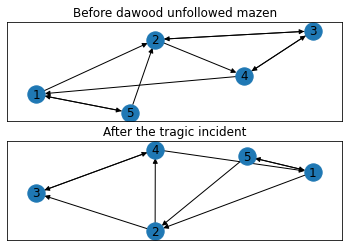

In [ ]:
Test()